In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import h5py
import cPickle as pickle

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from ToyMC.utils.Utils import is_logarithmic

In [16]:
LEVEL = 7
NAME = '14585'
INFILE = NAME+'.pkl'
WEIGHT_FILE = NAME+'_weights.hdf5'
X_PARMS = ['energy']
Y_PARMS = ['Ws']
INT = 'cc'
X_LABEL = 'E'
Y_LABEL = 'Ws'
BINNING = (np.logspace(0, 3, 20), np.linspace(0, 5, 20))

In [7]:
infile = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+INFILE
inweights = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+WEIGHT_FILE
input_file = pickle.load(open(infile, 'rb'))
if '16' in NAME:
    weights = np.ones(len(input_file['cc']))
else:
    weights = np.array(h5py.File(inweights, 'r')['weights'][:])

In [8]:
print(sorted(input_file.keys()))
print(weights.shape)

['A', 'Ef', 'Ei', 'El', 'En', 'Ev', 'KEf', 'KEl', 'Q2', 'Q2s', 'W', 'Ws', 'Z', '_azimax', '_azimin', '_elogmax', '_elogmin', '_glbprbscale', '_gvold', '_gvoll', '_gvolr', '_ngennu', '_plawind', '_zenmax', '_zenmin', 'calresp0', 'cc', 'charm', 'coh', 'dfr', 'diffxsec', 'dis', 'em', 'energy', 'hitnuc', 'hitqrk', 'iev', 'imd', 'nc', 'neu', 'neut_code', 'nf', 'nfem', 'nfk0', 'nfkm', 'nfkp', 'nfn', 'nfother', 'nfp', 'nfpi0', 'nfpim', 'nfpip', 'ni', 'niem', 'nik0', 'nikm', 'nikp', 'nin', 'niother', 'nip', 'nipi0', 'nipim', 'nipip', 'nuance_code', 'nuel', 'pdgf', 'pdgi', 'pdgl', 'prob', 'pxf', 'pxi', 'pxl', 'pxn', 'pxv', 'pyf', 'pyi', 'pyl', 'pyn', 'pyv', 'pzf', 'pzi', 'pzl', 'pzn', 'pzv', 'qel', 'res', 'resc', 'resid', 'rw_AhtBY', 'rw_BhtBY', 'rw_CV1uBY', 'rw_CV2uBY', 'rw_MaCCQE', 'rw_MaCCRES', 'rw_MaCOHpi', 'rw_MaNCEL', 'rw_MaNCRES', 'sea', 't', 'tgt', 'tgtmass', 'ts', 'vtxt', 'vtxx', 'vtxy', 'vtxz', 'wght', 'x', 'xs', 'xsec', 'y', 'ys']
(509542,)


In [9]:
if not np.sum(weights) == len(input_file['cc']):
    weights *= 3600 * 24 * 365.
    if LEVEL == 0:
        weights /= 3.
    elif LEVEL == 7:
        if '12585' in INFILE:
            weights /= 275.
        elif '14585' in INFILE:
            weights /= 245.
else:
    print(weights)

In [10]:
def make_plot_2D(hist, extra_label, outname, colour):

    fig = plt.figure(figsize=[14, 9])
    if LEVEL == 0:
        fig.suptitle('Level0 (Generator level) '+NAME, y=1.005)
    elif LEVEL == 7:
        fig.suptitle('Level7 (Final level) '+NAME, y=1.005)
    gs = gridspec.GridSpec(1, 1)
    gs0 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0], wspace=0.2, width_ratios=[10, 1])
    
    ax0 = fig.add_subplot(gs0[0])
    ax0.set_xlabel(X_LABEL+' '+extra_label, size=18)
    ax0.set_xlim(np.min(BINNING[0]), np.max(BINNING[0]))
    ax0.set_ylim(np.min(BINNING[1]), np.max(BINNING[1]))
    if is_logarithmic(BINNING[0]):
        ax0.set_xscale('log')
    if is_logarithmic(BINNING[1]):
        ax0.set_yscale('log')
    for xmaj in BINNING[0]:
        ax0.axvline(x=xmaj, ls='--', color='gray', alpha=0.7, linewidth=1)
    for ymaj in BINNING[1]:
        ax0.axhline(y=ymaj, ls='--', color='gray', alpha=0.7, linewidth=1)
    ax0.set_ylabel(Y_LABEL+' '+extra_label, size=18)
    
    hist_t = hist.T
    cax = ax0.pcolormesh(BINNING[0], BINNING[1], hist_t, cmap=plt.get_cmap(colour),
                         norm=colors.LogNorm(vmin=1E1, vmax=1E6))
    cb = fig.colorbar(cax, ax=ax0)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(r'# Events', fontsize=18)
    
    for edex, eedge in enumerate(BINNING[0][:-1]):
        for zdex, zedge in enumerate(BINNING[1][:-1]):
            text_color = 'black' if int(hist[edex][zdex])<5E3 else 'white'
            ax0.annotate(int(hist[edex][zdex]),
                         xy=(BINNING[0][edex]+(BINNING[0][edex+1]-BINNING[0][edex])/14.,
                             BINNING[1][zdex]+(BINNING[1][zdex+1]-BINNING[1][zdex])/3.),
                         xycoords='data', color=text_color, fontsize=8)

    
    fig.tight_layout()
    # fig.savefig('./test.pdf', bbox_inches='tight')
    fig.savefig(outname, bbox_inches='tight')

In [17]:
parm_array = np.zeros(len(input_file['cc']))
y_array = np.zeros(len(input_file['cc']))
for x in X_PARMS:
    parm_array += input_file[x]
nan_mask = np.isnan(parm_array)
for y in Y_PARMS:
    y_array += input_file[y]
nan_mask = nan_mask | np.isnan(y_array)
print('{0} nan values'.format(np.sum(nan_mask)))
int_mask = input_file[INT].astype(bool)
tot_mask = [~nan_mask & int_mask]
dis_hist, xedges, yedges = np.histogram2d(
    (parm_array[tot_mask])[input_file['dis'][tot_mask]],
    (y_array[tot_mask])[input_file['dis'][tot_mask]], bins=BINNING,
    weights=(weights[tot_mask])[input_file['dis'][tot_mask]]
)
res_hist, xedges, yedges = np.histogram2d(
    (parm_array[tot_mask])[input_file['res'][tot_mask]],
    (y_array[tot_mask])[input_file['res'][tot_mask]], bins=BINNING,
    weights=(weights[tot_mask])[input_file['res'][tot_mask]]
)
qel_hist, xedges, yedges = np.histogram2d(
    (parm_array[tot_mask])[input_file['qel'][tot_mask]],
    (y_array[tot_mask])[input_file['qel'][tot_mask]], bins=BINNING,
    weights=(weights[tot_mask])[input_file['qel'][tot_mask]]
)
all_hist, xedges, yedges = np.histogram2d(
    parm_array[tot_mask], y_array[tot_mask], bins=BINNING,
    weights=weights[tot_mask]
)
outfile = './images/level'+str(LEVEL)+'/2D/'+NAME+'_'+X_LABEL+'_'+Y_LABEL+'_'+INT

0 nan values


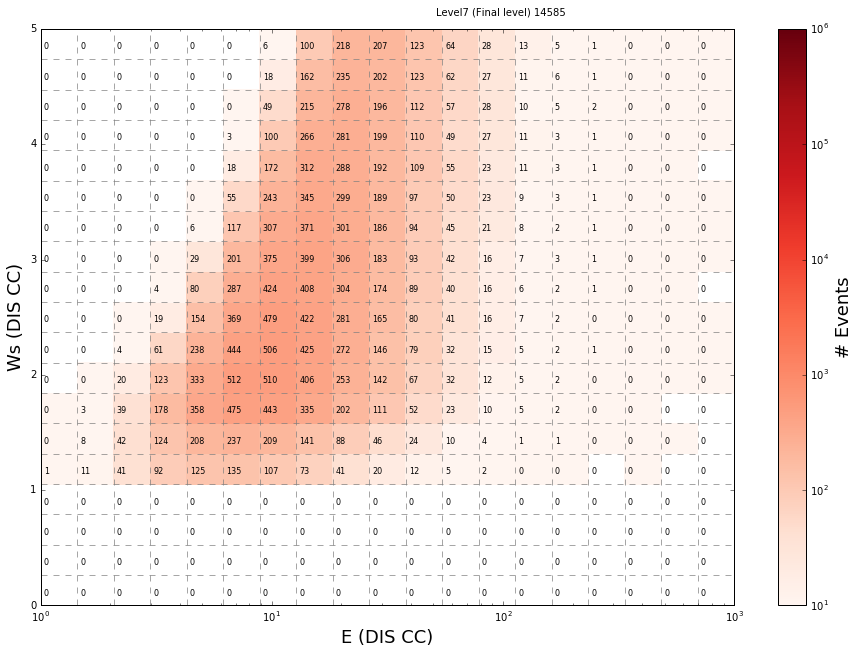

In [18]:
make_plot_2D(dis_hist, r'(DIS '+INT.upper()+')', outfile+'_dis.png', 'Reds')

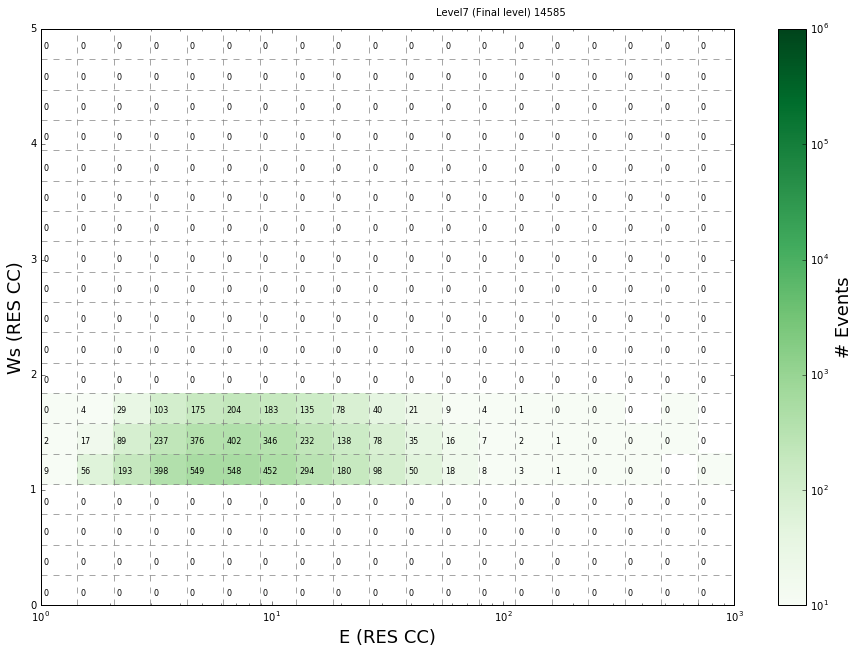

In [19]:
make_plot_2D(res_hist, r'(RES '+INT.upper()+')', outfile+'_res.png', 'Greens')

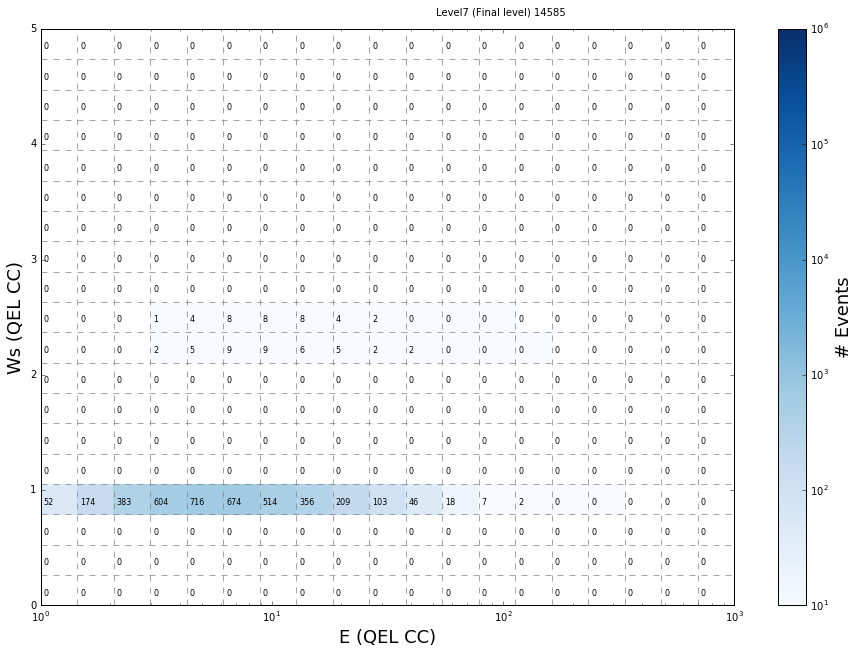

In [20]:
make_plot_2D(qel_hist, r'(QEL '+INT.upper()+')', outfile+'_qel.png', 'Blues')

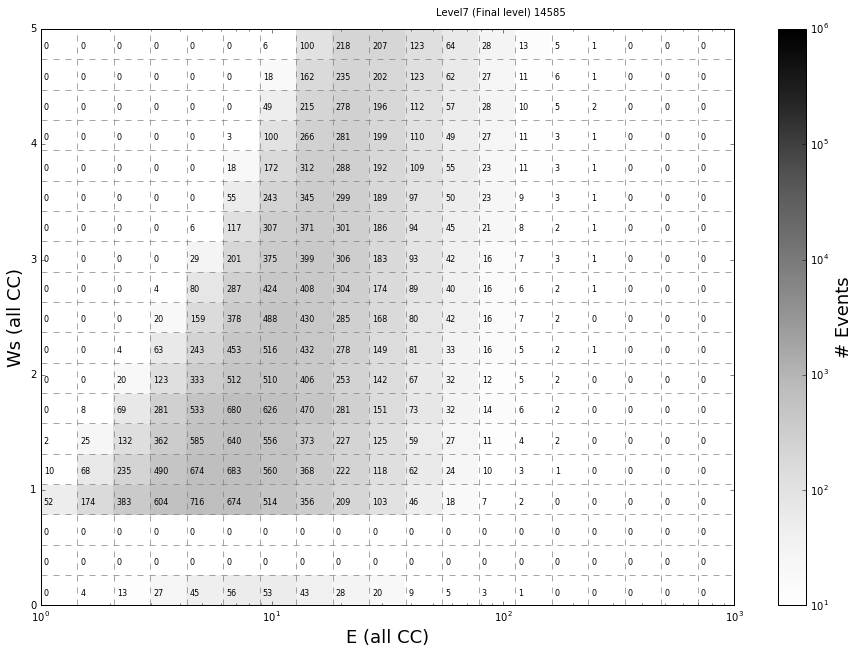

In [21]:
make_plot_2D(all_hist, r'(all '+INT.upper()+')', outfile+'_all.png', 'Greys')